# TRENDS FOR GRIDMET

In [19]:
import xarray as xr
import numpy as np
from scipy.stats import linregress
import os

def calculate_cdd(temp_data, threshold=0):
    """Calculate CDD (Cold Degree Days) from daily temperature data."""
    # CDD is calculated as the sum of days where temperature is below the threshold
    cdd = xr.where(temp_data < threshold, threshold - temp_data, 0).resample(time='Y').sum(dim='time')
    return cdd

def calculate_individual_trends(annual_cdd):
    """Calculate linear trends for the CDD data."""
    lat, lon = annual_cdd.lat.values, annual_cdd.lon.values
    years = annual_cdd['time.year'].values
    slopes = np.full((len(lat), len(lon)), np.nan)
    p_values = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            y = annual_cdd.isel(lat=i, lon=j).values
            if not np.all(np.isnan(y)):  # Ensure there's at least some data
                slope, intercept, r_value, p_value, std_err = linregress(years, y)
                slopes[i, j] = slope
                p_values[i, j] = p_value

    trends_da = xr.DataArray(data=slopes, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})
    p_values_da = xr.DataArray(data=p_values, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})

    return trends_da, p_values_da

# Load observed temperature data
observed_data_path = '/home/shawn_preston/tmax/modified_regridded1979_2022_tavg_gridmet.nc'
observed_data = xr.open_dataset(observed_data_path)
observed_temp_data = observed_data['tavg']  # Ensure this is the correct variable name

# Calculate CDD for observed data
observed_cdd = calculate_cdd(observed_temp_data)

# Calculate trends for observed CDD data
observed_trends_da, observed_p_values_da = calculate_individual_trends(observed_cdd)

# Compile into a Dataset
observed_trends_ds = xr.Dataset({
    "observed_cdd_yearly": observed_cdd,
    "observed_trends": observed_trends_da,
    "observed_p_values": observed_p_values_da
}, coords={"lat": observed_data.lat, "lon": observed_data.lon})

# Save to a NetCDF file
output_nc_file = '/home/shawn_preston/daysbelow0ensemble/gridmet_trends_cdd_analysis.nc'
observed_trends_ds.to_netcdf(output_nc_file)

print(f"Saved the observed CDD trends to {output_nc_file}")


Saved the observed CDD trends to /home/shawn_preston/daysbelow0ensemble/gridmet_trends_cdd_analysis.nc


In [7]:
import xarray as xr
import numpy as np
from scipy.stats import linregress

def filter_months(data, start_month=1, end_month=7):
    """Filter data to include only the specified months."""
    months = list(range(start_month, 13)) + list(range(1, end_month + 1)) if start_month > end_month else list(range(start_month, end_month + 1))
    return data.sel(time=data['time.month'].isin(months))

def calculate_last_frost_date(data):
    """Calculate the last frost day of the year for each year."""
    frost_days = data <= 0  # Assuming data is already in Celsius
    frost_day_of_year = frost_days.where(frost_days, other=0) * data['time'].dt.dayofyear
    last_frost_day_of_year = frost_day_of_year.groupby('time.year').max('time')
    return last_frost_day_of_year

def calculate_individual_trends(last_frost_dates):
    """Calculate linear trends for the last frost dates."""
    lat, lon = last_frost_dates.lat.values, last_frost_dates.lon.values
    years = last_frost_dates['year'].values
    slopes = np.full((len(lat), len(lon)), np.nan)
    p_values = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            y = last_frost_dates.isel(lat=i, lon=j).values
            if not np.all(np.isnan(y)):  # Ensure there's at least some data
                slope, intercept, r_value, p_value, std_err = linregress(years, y)
                slopes[i, j] = slope
                p_values[i, j] = p_value

    trends_da = xr.DataArray(data=slopes, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})
    p_values_da = xr.DataArray(data=p_values, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})

    return trends_da, p_values_da

# Load observed temperature data
observed_data_path = '/home/shawn_preston/tmax/modified_regridded1979_2022_tmin_gridmet.nc'
observed_data = xr.open_dataset(observed_data_path)
observed_temp_data = observed_data['tmin']  # Ensure this is the correct variable name

# Filter data for the relevant months
filtered_data = filter_months(observed_temp_data)

# Calculate last frost dates for observed data
last_frost_dates = calculate_last_frost_date(filtered_data)

# Calculate trends for last frost dates
observed_trends_da, observed_p_values_da = calculate_individual_trends(last_frost_dates)

# Compile into a Dataset
observed_trends_ds = xr.Dataset({
    "observed_last_frost_dates_yearly": last_frost_dates,
    "observed_trends": observed_trends_da,
    "observed_p_values": observed_p_values_da
}, coords={"lat": observed_data.lat, "lon": observed_data.lon})

# Save to a NetCDF file
output_nc_file = '/home/shawn_preston/lastdayfrostensemble/gridmet_trends_last_frost_analysis.nc'
observed_trends_ds.to_netcdf(output_nc_file)

print(f"Saved the observed last frost date trends to {output_nc_file}")


Saved the observed last frost date trends to /home/shawn_preston/lastdayfrostensemble/gridmet_trends_last_frost_analysis.nc


In [23]:
import xarray as xr
import numpy as np
from scipy.stats import linregress

def filter_months_and_calculate_gdd(ds, baseline=6, max_threshold=28, start_month=1, end_month=4):
    """Filter data for specific months and calculate GDD."""
    # Select data for specific months
    filtered_data = ds.sel(time=ds['time.month'].isin(range(start_month, end_month + 1)))
    
    # Calculate the mean temperature using max temp capped at the upper threshold
    # and ensuring baseline is considered if the temperature is below it.
    tmax_capped = xr.where(filtered_data > max_threshold, max_threshold, filtered_data)
    tmin_adjusted = xr.where(filtered_data < baseline, baseline, filtered_data)
    mean_temp = (tmax_capped + tmin_adjusted) / 2
    
    # Calculate GDD ensuring that temperatures below the baseline yield zero GDD
    gdd = mean_temp - baseline
    gdd = xr.where(gdd > 0, gdd, 0)
    
    # Sum GDD across all days within each year
    yearly_gdd = gdd.groupby('time.year').sum(dim="time")
    return yearly_gdd

def calculate_individual_trends(annual_gdd):
    """Calculate linear trends for the GDD data."""
    lat, lon = annual_gdd.lat.values, annual_gdd.lon.values
    years = annual_gdd['year'].values
    slopes = np.full((len(lat), len(lon)), np.nan)
    p_values = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            y = annual_gdd.isel(lat=i, lon=j).values
            if not np.all(np.isnan(y)):  # Ensure there's at least some data
                slope, intercept, r_value, p_value, std_err = linregress(years, y)
                slopes[i, j] = slope
                p_values[i, j] = p_value

    trends_da = xr.DataArray(data=slopes, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})
    p_values_da = xr.DataArray(data=p_values, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})

    return trends_da, p_values_da

# Load observed temperature data
observed_data_path = '/home/shawn_preston/tmax/modified_regridded1979_2022_tavg_gridmet.nc'
observed_data = xr.open_dataset(observed_data_path)
observed_temp_data = observed_data['tavg']  # Ensure this is the correct variable name

# Calculate GDD for observed data
observed_gdd = filter_months_and_calculate_gdd(observed_temp_data)

# Calculate trends for observed GDD data
observed_trends_da, observed_p_values_da = calculate_individual_trends(observed_gdd)

# Compile into a Dataset
observed_trends_ds = xr.Dataset({
    "observed_gdd_yearly": observed_gdd,
    "observed_trends": observed_trends_da,
    "observed_p_values": observed_p_values_da
}, coords={"lat": observed_data.lat, "lon": observed_data.lon})

# Save to a NetCDF file
output_nc_file = '/home/shawn_preston/gddcesm2janapr/gridmet_trends_gddbb_analysis.nc'
observed_trends_ds.to_netcdf(output_nc_file)

print(f"Saved the observed GDD trends to {output_nc_file}")


Saved the observed GDD trends to /home/shawn_preston/gddcesm2janapr/gridmet_trends_gddbb_analysis.nc


In [24]:
import xarray as xr
import numpy as np
from scipy.stats import linregress

def filter_months_and_calculate_gdd(ds, baseline=6, max_threshold=28, start_month=1, end_month=9):
    """Filter data for specific months and calculate GDD."""
    # Select data for specific months
    filtered_data = ds.sel(time=ds['time.month'].isin(range(start_month, end_month + 1)))
    
    # Calculate the mean temperature using max temp capped at the upper threshold
    # and ensuring baseline is considered if the temperature is below it.
    tmax_capped = xr.where(filtered_data > max_threshold, max_threshold, filtered_data)
    tmin_adjusted = xr.where(filtered_data < baseline, baseline, filtered_data)
    mean_temp = (tmax_capped + tmin_adjusted) / 2
    
    # Calculate GDD ensuring that temperatures below the baseline yield zero GDD
    gdd = mean_temp - baseline
    gdd = xr.where(gdd > 0, gdd, 0)
    
    # Sum GDD across all days within each year
    yearly_gdd = gdd.groupby('time.year').sum(dim="time")
    return yearly_gdd

def calculate_individual_trends(annual_gdd):
    """Calculate linear trends for the GDD data."""
    lat, lon = annual_gdd.lat.values, annual_gdd.lon.values
    years = annual_gdd['year'].values
    slopes = np.full((len(lat), len(lon)), np.nan)
    p_values = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            y = annual_gdd.isel(lat=i, lon=j).values
            if not np.all(np.isnan(y)):  # Ensure there's at least some data
                slope, intercept, r_value, p_value, std_err = linregress(years, y)
                slopes[i, j] = slope
                p_values[i, j] = p_value

    trends_da = xr.DataArray(data=slopes, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})
    p_values_da = xr.DataArray(data=p_values, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})

    return trends_da, p_values_da

# Load observed temperature data
observed_data_path = '/home/shawn_preston/tmax/modified_regridded1979_2022_tavg_gridmet.nc'
observed_data = xr.open_dataset(observed_data_path)
observed_temp_data = observed_data['tavg']  # Ensure this is the correct variable name

# Calculate GDD for observed data
observed_gdd = filter_months_and_calculate_gdd(observed_temp_data)

# Calculate trends for observed GDD data
observed_trends_da, observed_p_values_da = calculate_individual_trends(observed_gdd)

# Compile into a Dataset
observed_trends_ds = xr.Dataset({
    "observed_gdd_yearly": observed_gdd,
    "observed_trends": observed_trends_da,
    "observed_p_values": observed_p_values_da
}, coords={"lat": observed_data.lat, "lon": observed_data.lon})

# Save to a NetCDF file
output_nc_file = '/home/shawn_preston/gddcdesm2jansept/gridmet_trends_gddgg_analysis.nc'
observed_trends_ds.to_netcdf(output_nc_file)

print(f"Saved the observed GDD trends to {output_nc_file}")


Saved the observed GDD trends to /home/shawn_preston/gddcdesm2jansept/gridmet_trends_gddgg_analysis.nc


In [25]:
import xarray as xr
import numpy as np
from scipy.stats import linregress

def filter_months_and_calculate_days_above(ds, threshold=34, start_month=6, end_month=8):
    """Filter data for specific months and calculate days above the threshold."""
    # Select data for specific months
    filtered_data = ds.sel(time=ds['time.month'].isin(range(start_month, end_month + 1)))
    
    # Calculate days where temperature exceeds the threshold
    days_above = filtered_data > threshold
    
    # Sum days above threshold across all days within each year
    yearly_days_above = days_above.groupby('time.year').sum(dim="time")
    return yearly_days_above

def calculate_individual_trends(annual_days_above):
    """Calculate linear trends for the days above threshold data."""
    lat, lon = annual_days_above.lat.values, annual_days_above.lon.values
    years = annual_days_above['year'].values
    slopes = np.full((len(lat), len(lon)), np.nan)
    p_values = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            y = annual_days_above.isel(lat=i, lon=j).values
            if not np.all(np.isnan(y)):  # Ensure there's at least some data
                slope, intercept, r_value, p_value, std_err = linregress(years, y)
                slopes[i, j] = slope
                p_values[i, j] = p_value

    trends_da = xr.DataArray(data=slopes, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})
    p_values_da = xr.DataArray(data=p_values, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})

    return trends_da, p_values_da

# Load observed temperature data
observed_data_path = '/home/shawn_preston/tmax/modified_regridded1979_2022_tmax_gridmet.nc'
observed_data = xr.open_dataset(observed_data_path)
observed_temp_data = observed_data['tmax']  # Ensure this is the correct variable name

# Calculate days above threshold for observed data
observed_days_above = filter_months_and_calculate_days_above(observed_temp_data)

# Calculate trends for observed days above threshold data
observed_trends_da, observed_p_values_da = calculate_individual_trends(observed_days_above)

# Compile into a Dataset
observed_trends_ds = xr.Dataset({
    "observed_days_above_yearly": observed_days_above,
    "observed_trends": observed_trends_da,
    "observed_p_values": observed_p_values_da
}, coords={"lat": observed_data.lat, "lon": observed_data.lon})

# Save to a NetCDF file
output_nc_file = '/home/shawn_preston/tmax34ensemble/gridmet_trends_days_above_threshold_analysis.nc'
observed_trends_ds.to_netcdf(output_nc_file)

print(f"Saved the observed days above threshold trends to {output_nc_file}")


Saved the observed days above threshold trends to /home/shawn_preston/tmax34ensemble/gridmet_trends_days_above_threshold_analysis.nc


In [26]:
import xarray as xr
import numpy as np
from scipy.stats import linregress

def filter_months_and_calculate_days_above(ds, threshold=15, start_month=8, end_month=9):
    """Filter data for specific months and calculate days above the threshold."""
    # Select data for specific months
    filtered_data = ds.sel(time=ds['time.month'].isin(range(start_month, end_month + 1)))
    
    # Calculate days where temperature exceeds the threshold
    days_above = filtered_data > threshold
    
    # Sum days above threshold across all days within each year
    yearly_days_above = days_above.groupby('time.year').sum(dim="time")
    return yearly_days_above

def calculate_individual_trends(annual_days_above):
    """Calculate linear trends for the days above threshold data."""
    lat, lon = annual_days_above.lat.values, annual_days_above.lon.values
    years = annual_days_above['year'].values
    slopes = np.full((len(lat), len(lon)), np.nan)
    p_values = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            y = annual_days_above.isel(lat=i, lon=j).values
            if not np.all(np.isnan(y)):  # Ensure there's at least some data
                slope, intercept, r_value, p_value, std_err = linregress(years, y)
                slopes[i, j] = slope
                p_values[i, j] = p_value

    trends_da = xr.DataArray(data=slopes, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})
    p_values_da = xr.DataArray(data=p_values, dims=["lat", "lon"], coords={"lat": lat, "lon": lon})

    return trends_da, p_values_da

# Load observed temperature data
observed_data_path = '/home/shawn_preston/tmax/modified_regridded1979_2022_tmin_gridmet.nc'
observed_data = xr.open_dataset(observed_data_path)
observed_temp_data = observed_data['tmin']  # Ensure this is the correct variable name

# Calculate days above threshold for observed data
observed_days_above = filter_months_and_calculate_days_above(observed_temp_data)

# Calculate trends for observed days above threshold data
observed_trends_da, observed_p_values_da = calculate_individual_trends(observed_days_above)

# Compile into a Dataset
observed_trends_ds = xr.Dataset({
    "observed_days_above_yearly": observed_days_above,
    "observed_trends": observed_trends_da,
    "observed_p_values": observed_p_values_da
}, coords={"lat": observed_data.lat, "lon": observed_data.lon})

# Save to a NetCDF file
output_nc_file = '/home/shawn_preston/tmin15ensemble/gridmet_trends_days_above_threshold_analysis.nc'
observed_trends_ds.to_netcdf(output_nc_file)

print(f"Saved the observed days above threshold trends to {output_nc_file}")


Saved the observed days above threshold trends to /home/shawn_preston/tmin15ensemble/gridmet_trends_days_above_threshold_analysis.nc


Processing CESM2 file: /home/shawn_preston/weighted_cesm2/CDD_Trends_weighted.nc
Processing GridMET file: /home/shawn_preston/weighted_gridmet/CDD_Trends_weighted.nc
Variable name: ensemble_trends
CESM2 dataset variables: ['lat', 'lon', 'year', 'ensemble', 'ensemble_cdd_yearly', 'ensemble_trends', 'ensemble_p_values', 'mean_trend', 'mean_p_values']
GridMET dataset variables: ['lat', 'lon', 'time', 'observed_cdd_yearly', 'observed_trends', 'observed_p_values']
Processing CESM2 file: /home/shawn_preston/weighted_cesm2/Last_Frost_Date_Trends_weighted.nc
Processing GridMET file: /home/shawn_preston/weighted_gridmet/Last_Frost_Date_Trends_weighted.nc
Variable name: ensemble_trends
CESM2 dataset variables: ['lat', 'lon', 'year', 'ensemble', 'ensemble_last_frost_dates_yearly', 'ensemble_trends', 'ensemble_p_values', 'mean_trend', 'mean_p_values']
GridMET dataset variables: ['lon', 'lat', 'year', 'observed_last_frost_dates_yearly', 'observed_trends', 'observed_p_values']
Processing CESM2 file:

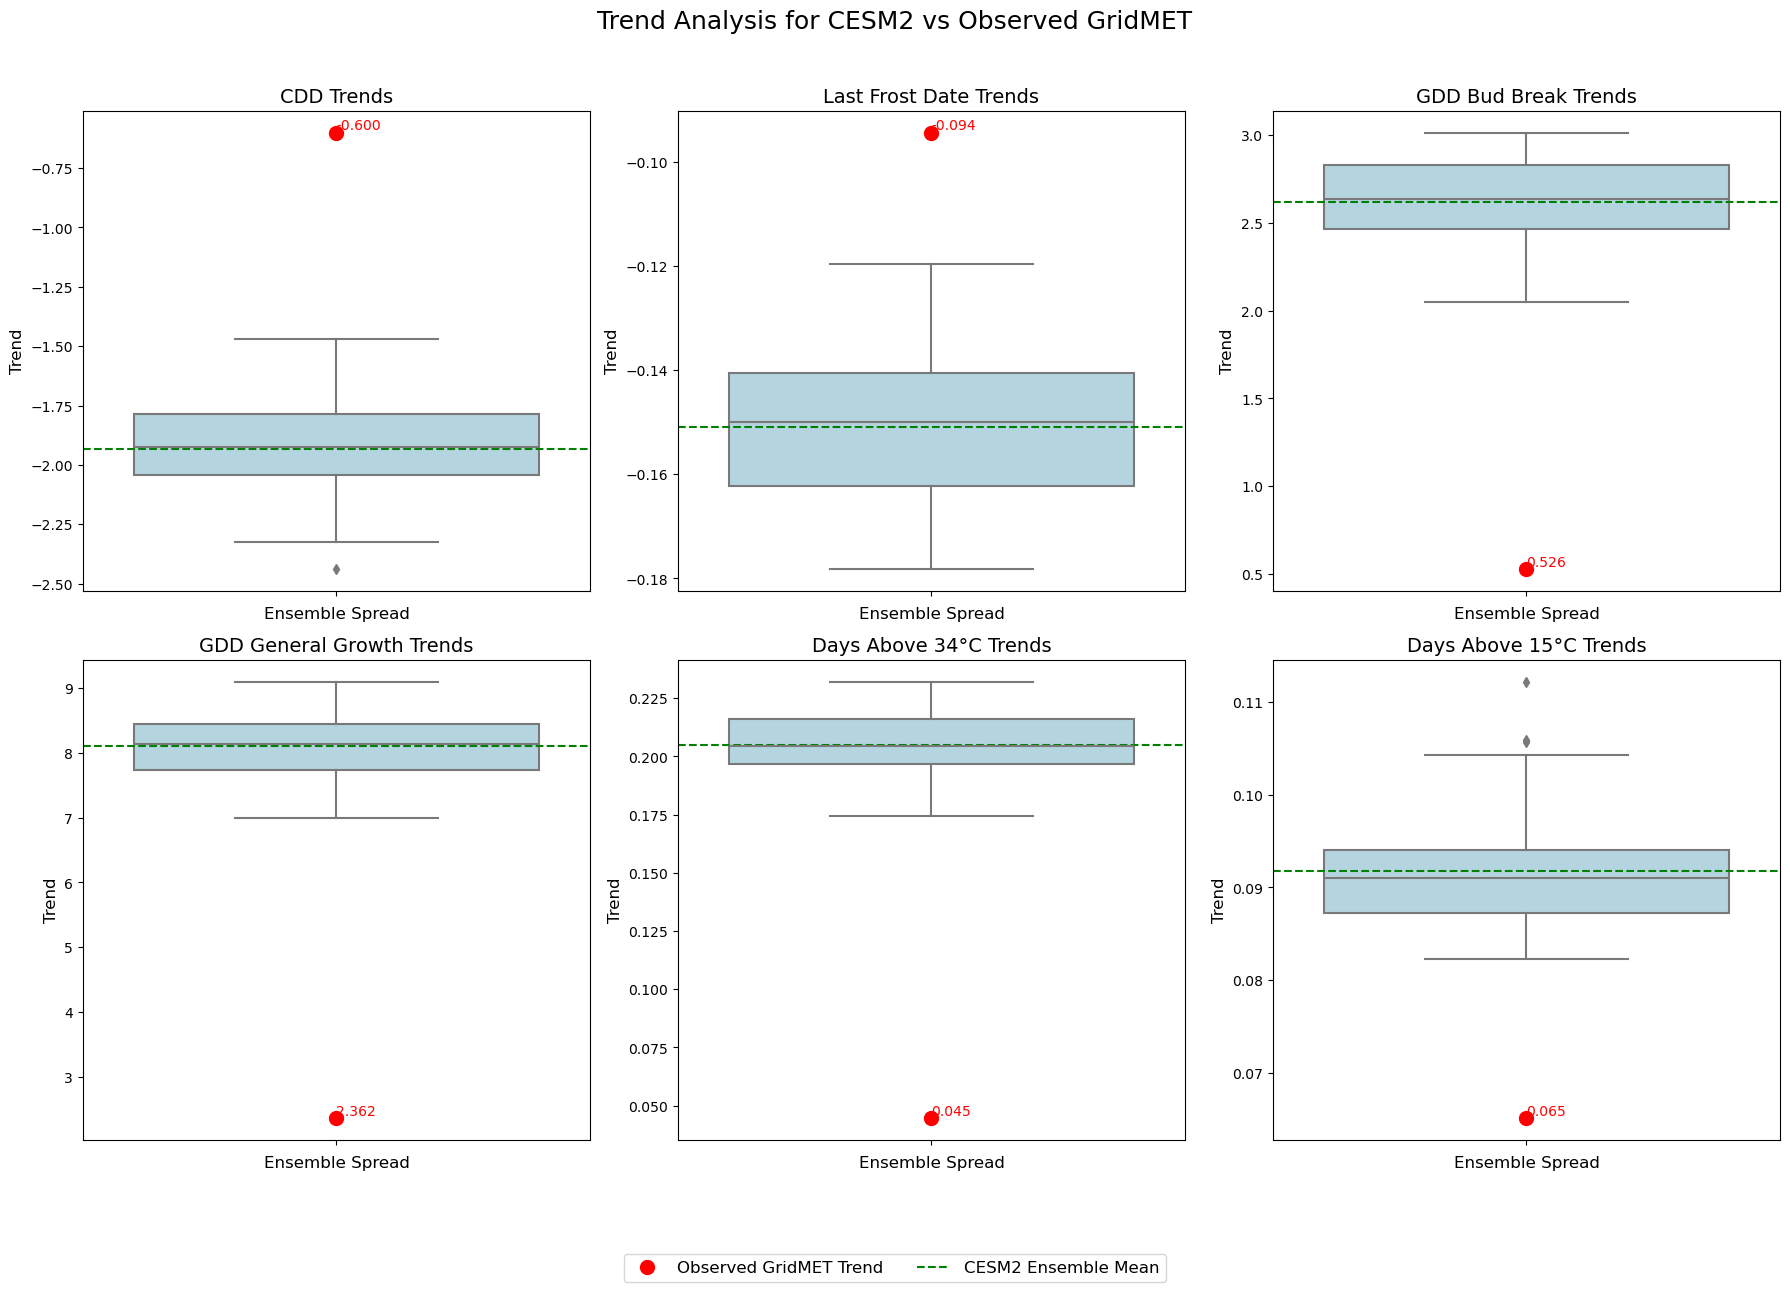

Saved the panel plot to /home/shawn_preston/CESM2PAPERFIGURES/Trend_Analysis_2x3_Panel.pdf


In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# File paths and variable names for each metric
metrics = [
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/CDD_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/CDD_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'CDD Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/Last_Frost_Date_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/Last_Frost_Date_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'Last Frost Date Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/GDD_Bud_Break_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/GDD_Bud_Break_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'GDD Bud Break Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/GDD_General_Growth_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/GDD_General_Growth_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'GDD General Growth Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/Days_Above_34°C_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/Days_Above_34°C_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'Days Above 34°C Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/Days_Above_15°C_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/Days_Above_15°C_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'Days Above 15°C Trends'}
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for idx, metric in enumerate(metrics):
    cesm2_path = metric['cesm2_path']
    gridmet_path = metric['gridmet_path']
    variable_name = metric['variable_name']
    gridmet_variable_name = metric['gridmet_variable_name']
    title = metric['title']
    
    # Load CESM2 and GridMET data
    cesm2_ds = xr.open_dataset(cesm2_path)
    gridmet_ds = xr.open_dataset(gridmet_path)
    
    print(f"Processing CESM2 file: {cesm2_path}")
    print(f"Processing GridMET file: {gridmet_path}")
    print(f"Variable name: {variable_name}")
    
    print("CESM2 dataset variables:", list(cesm2_ds.variables))
    print("GridMET dataset variables:", list(gridmet_ds.variables))
    
    if variable_name in cesm2_ds.variables:
        cesm2_trends = cesm2_ds[variable_name]
    else:
        print(f"Variable {variable_name} not found in CESM2 dataset")
        continue
    
    if gridmet_variable_name in gridmet_ds.variables:
        gridmet_trend = gridmet_ds[gridmet_variable_name].values  # Single value
    else:
        print(f"Variable {gridmet_variable_name} not found in GridMET dataset")
        continue

    # Calculate the ensemble mean for CESM2
    ensemble_mean = cesm2_trends.mean(dim='ensemble').values
    
    row, col = divmod(idx, 3)
    ax = axes[row, col]

    # Create the boxplot
    sns.boxplot(data=cesm2_trends.values.T, color='lightblue', ax=ax)
    ax.plot(0, gridmet_trend, 'ro', label='Observed GridMET Trend', markersize=10)
    ax.axhline(y=ensemble_mean, color='g', linestyle='--', label='CESM2 Ensemble Mean')

    # Add the text next to the red circle
    ax.text(0, gridmet_trend, f"{gridmet_trend:.3f}", color='red', fontsize=10, ha='left', va='bottom')

    # Customize the plot
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Trend', fontsize=12)
    ax.set_xlabel('Ensemble Spread', fontsize=12)
    ax.set_xticklabels([''])

# Move the legend outside the subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

plt.suptitle('Trend Analysis for CESM2 vs Observed GridMET', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot
output_plot_path = '/home/shawn_preston/CESM2PAPERFIGURES/Trend_Analysis_2x3_Panel.pdf'
plt.savefig(output_plot_path, format='pdf', dpi=600)
plt.show()

print(f"Saved the panel plot to {output_plot_path}")


ValueError: x and y must have same first dimension, but have shapes (1,) and (10, 13)

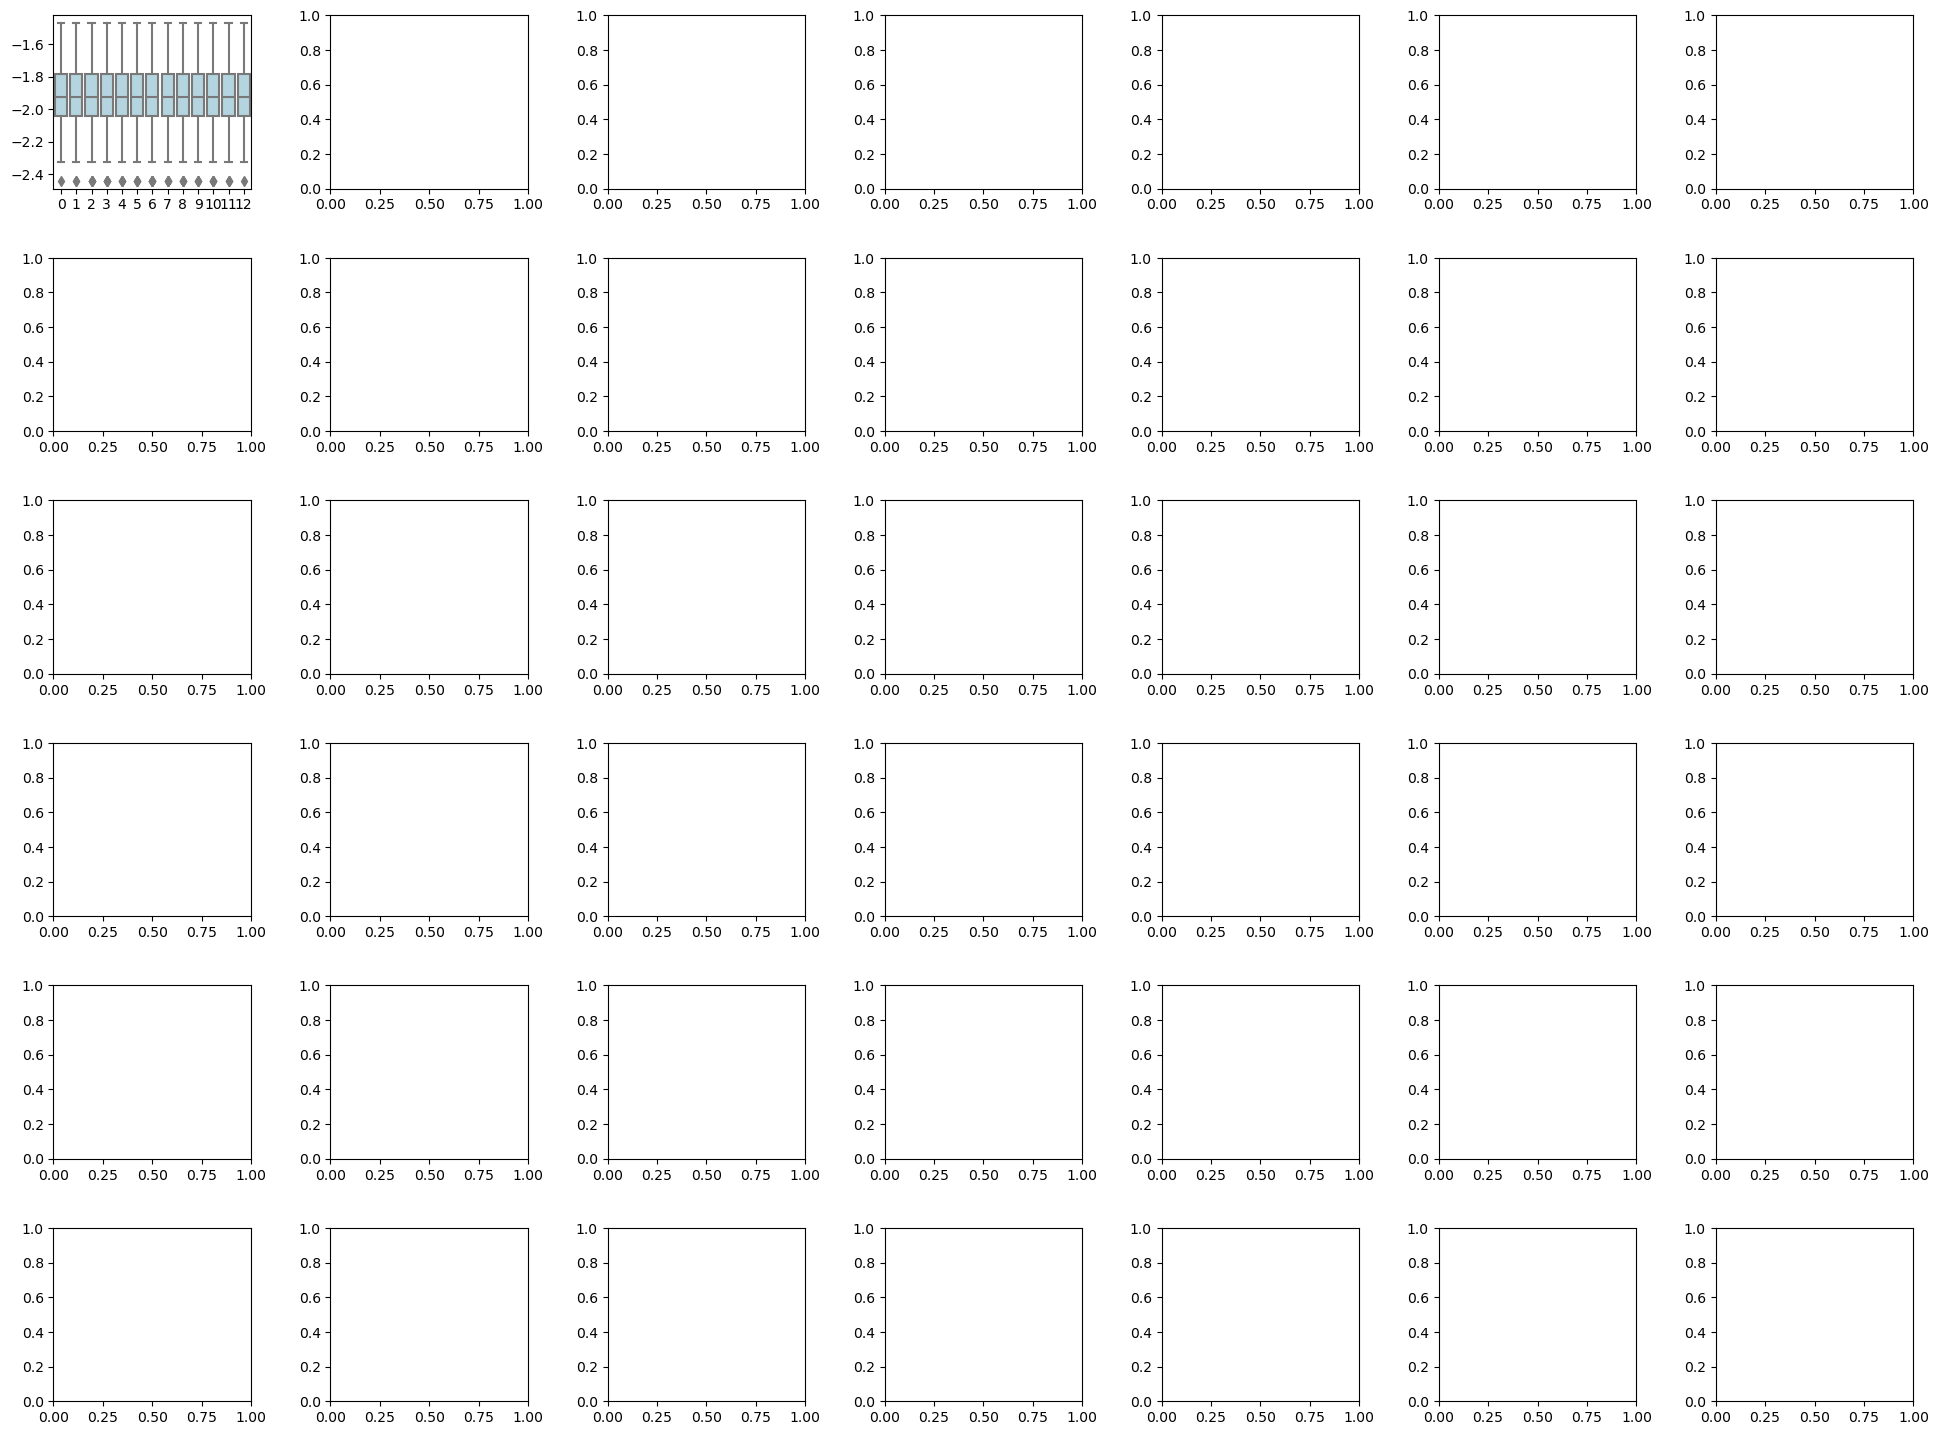

In [13]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import regionmask

# Define the shapefile path and load it
shapefile_path = '/home/shawn_preston/NCA/NCA_Regions.shp'
regions_gdf = gpd.read_file(shapefile_path)

# Define the regions of interest
regions = ['Northeast', 'Southeast', 'Midwest', 'Northern Great Plains', 'Southern Plains', 'Southwest', 'Northwest']

# File paths and variable names for each metric
metrics = [
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/CDD_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/CDD_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'CDD Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/Last_Frost_Date_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/Last_Frost_Date_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'Last Frost Date Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/GDD_Bud_Break_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/GDD_Bud_Break_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'GDD Bud Break Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/GDD_General_Growth_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/GDD_General_Growth_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'GDD General Growth Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/Days_Above_34°C_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/Days_Above_34°C_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'Days Above 34°C Trends'},
    {'cesm2_path': '/home/shawn_preston/weighted_cesm2/Days_Above_15°C_Trends_weighted.nc', 
     'gridmet_path': '/home/shawn_preston/weighted_gridmet/Days_Above_15°C_Trends_weighted.nc', 
     'variable_name': 'ensemble_trends', 
     'gridmet_variable_name': 'observed_trends',
     'title': 'Days Above 15°C Trends'}
]

fig, axes = plt.subplots(len(metrics), len(regions), figsize=(24, 18))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, metric in enumerate(metrics):
    cesm2_path = metric['cesm2_path']
    gridmet_path = metric['gridmet_path']
    variable_name = metric['variable_name']
    gridmet_variable_name = metric['gridmet_variable_name']
    title = metric['title']

    cesm2_ds = xr.open_dataset(cesm2_path)
    gridmet_ds = xr.open_dataset(gridmet_path)

    for j, region_name in enumerate(regions):
        region_gdf = regions_gdf[regions_gdf['RegionName'] == region_name]
        
        # Mask the CESM2 data for the region
        mask = regionmask.mask_geopandas(region_gdf, cesm2_ds.lon, cesm2_ds.lat)
        cesm2_region = cesm2_ds.where(mask == 0, drop=True)
        cesm2_trends = cesm2_region[variable_name]

        # Mask the GridMET data for the region
        mask = regionmask.mask_geopandas(region_gdf, gridmet_ds.lon, gridmet_ds.lat)
        gridmet_region = gridmet_ds.where(mask == 0, drop=True)
        gridmet_trend = gridmet_region[gridmet_variable_name].values

        # Flatten the CESM2 trends data to 2D
        cesm2_trends_flat = cesm2_trends.values.reshape(-1, cesm2_trends.shape[-1])

        # Calculate the ensemble mean for CESM2
        ensemble_mean = cesm2_trends.mean(dim='ensemble').values

        ax = axes[i, j]

        # Create the boxplot
        sns.boxplot(data=cesm2_trends_flat, color='lightblue', ax=ax)
        ax.plot(0, gridmet_trend, 'ro', markersize=10)
        ax.axhline(y=ensemble_mean, color='g', linestyle='--')

        # Add the text next to the red circle
        ax.text(0, gridmet_trend, f"{gridmet_trend:.3f}", color='red', fontsize=10, ha='left', va='bottom')

        # Customize the plot
        ax.set_title(f"{title}\n{region_name}", fontsize=12)
        ax.set_ylabel('Trend', fontsize=10)
        ax.set_xlabel('Ensemble Spread', fontsize=10)
        ax.set_xticklabels([''])

# Move the legend outside the subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

plt.suptitle('Regional Trend Analysis for CESM2 vs Observed GridMET', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot
output_plot_path = '/home/shawn_preston/CESM2PAPERFIGURES/Regional_Trend_Analysis.pdf'
plt.savefig(output_plot_path, format='pdf', dpi=600)
plt.show()

print(f"Saved the panel plot to {output_plot_path}")


In [9]:
import numpy as np
import xarray as xr
import os

def earth_radius(lat):
    """
    Calculate the radius of Earth assuming an oblate spheroid defined by WGS84.
    """
    a = 6378137  # semi-major axis in meters
    b = 6356752.3142  # semi-minor axis in meters
    e2 = 1 - (b**2 / a**2)  # square of eccentricity
    
    lat_rad = np.deg2rad(lat)  # convert from degrees to radians
    lat_gc = np.arctan((1 - e2) * np.tan(lat_rad))  # convert from geodetic to geocentric
    
    r = (a * (1 - e2)**0.5) / (1 - (e2 * np.cos(lat_gc)**2))**0.5
    return r

def area_grid(lat, lon):
    """
    Calculate the area of each grid cell in square meters.
    """
    lon, lat = np.meshgrid(lon, lat)  
    R = earth_radius(lat)
    
    dlat = np.deg2rad(np.gradient(lat, axis=0))
    dlon = np.deg2rad(np.gradient(lon, axis=1))
    
    dy = dlat * R
    dx = dlon * R * np.cos(np.deg2rad(lat))
    
    area = dy * dx  # Area calculation
    return area

# Unique latitudes and longitudes provided
latitudes = np.array([25.91623037, 26.85863874, 27.80104712, 28.7434555, 29.68586387, 
                      30.62827225, 31.57068063, 32.51308901, 33.45549738, 34.39790576, 
                      35.34031414, 36.28272251, 37.22513089, 38.16753927, 39.10994764, 
                      40.05235602, 40.9947644, 41.93717277, 42.87958115, 43.82198953, 
                      44.76439791, 45.70680628, 46.64921466, 47.59162304, 48.53403141, 
                      49.47643979])
longitudes = np.array([235., 236.25, 237.5, 238.75, 240., 241.25, 242.5, 243.75, 245., 246.25,
                       247.5, 248.75, 250., 251.25, 252.5, 253.75, 255., 256.25, 257.5, 258.75,
                       260., 261.25, 262.5, 263.75, 265., 266.25, 267.5, 268.75, 270., 271.25,
                       272.5, 273.75, 275., 276.25, 277.5, 278.75, 280., 281.25, 282.5, 283.75,
                       285., 286.25, 287.5, 288.75, 290., 291.25, 292.5, 293.75, 295.])

# Calculate the area of each grid cell
area = area_grid(latitudes, longitudes)
print(f"Area grid shape: {area.shape}")
print(f"Area grid sample values:\n{area[:5, :5]}")

total_area = np.sum(area)
print(f"Total area: {total_area}")

# Compute the normalization factor for each cell relative to the average area
average_area_per_cell = total_area / area.size
normalized_areas = area / average_area_per_cell
print(f"Normalized areas shape: {normalized_areas.shape}")
print(f"Normalized areas sample values:\n{normalized_areas[:5, :5]}")

# File paths and variable names for each metric
metrics = [
    {'observed_path': '/home/shawn_preston/daysbelow0ensemble/gridmet_trends_cdd_analysis.nc', 
     'variable_name': 'observed_trends', 
     'title': 'CDD Trends'},
    {'observed_path': '/home/shawn_preston/lastdayfrostensemble/gridmet_trends_last_frost_analysis.nc', 
     'variable_name': 'observed_trends', 
     'title': 'Last Frost Date Trends'},
    {'observed_path': '/home/shawn_preston/gddcesm2janapr/gridmet_trends_gddbb_analysis.nc', 
     'variable_name': 'observed_trends', 
     'title': 'GDD Bud Break Trends'},
    {'observed_path': '/home/shawn_preston/gddcdesm2jansept/gridmet_trends_gddgg_analysis.nc', 
     'variable_name': 'observed_trends', 
     'title': 'GDD General Growth Trends'},
    {'observed_path': '/home/shawn_preston/tmax34ensemble/gridmet_trends_days_above_threshold_analysis.nc', 
     'variable_name': 'observed_trends', 
     'title': 'Days Above 34°C Trends'},
    {'observed_path': '/home/shawn_preston/tmin15ensemble/gridmet_trends_days_above_threshold_analysis.nc', 
     'variable_name': 'observed_trends', 
     'title': 'Days Above 15°C Trends'}
]

# Base path for saving new files
base_path = "/home/shawn_preston/weighted_gridmet"

if not os.path.exists(base_path):
    os.makedirs(base_path)  # Create the directory 

# Process each file
for metric in metrics:
    observed_path = metric['observed_path']
    variable_name = metric['variable_name']
    
    # Load the original data
    ds = xr.open_dataset(observed_path)
    data = ds[variable_name]
    print(f"Processing {observed_path} with variable {variable_name}")
    print(f"Original data shape: {data.shape}")
    
    # Regrid data to match the dimensions of normalized_areas
    regridded_data = data.interp(lat=latitudes, lon=longitudes)
    print(f"Regridded data shape: {regridded_data.shape}")
    
    # Apply normalized areas
    weighted_data = (regridded_data * normalized_areas).sum(dim=['lat', 'lon']) / normalized_areas.sum()
    print(f"Weighted data: {weighted_data}")
    
    # Update the dataset
    weighted_data_da = xr.DataArray(weighted_data, dims=[], attrs=data.attrs)
    ds[variable_name] = weighted_data_da
    
    # Define new file path
    new_file_name = f"{metric['title'].replace(' ', '_')}_weighted.nc"
    new_file_path = os.path.join(base_path, new_file_name)

    # Save the modified dataset 
    ds.to_netcdf(new_file_path)
    
    print(f'Processed and saved weighted data for {variable_name} in {new_file_path}')


Area grid shape: (26, 49)
Area grid sample values:
[[1.31131848e+10 1.31131848e+10 1.31131848e+10 1.31131848e+10
  1.31131848e+10]
 [1.30054710e+10 1.30054710e+10 1.30054710e+10 1.30054710e+10
  1.30054710e+10]
 [1.28942299e+10 1.28942299e+10 1.28942299e+10 1.28942299e+10
  1.28942299e+10]
 [1.27794941e+10 1.27794941e+10 1.27794941e+10 1.27794941e+10
  1.27794941e+10]
 [1.26612974e+10 1.26612974e+10 1.26612974e+10 1.26612974e+10
  1.26612974e+10]]
Total area: 14568323624969.896
Normalized areas shape: (26, 49)
Normalized areas sample values:
[[1.1467481  1.1467481  1.1467481  1.1467481  1.1467481 ]
 [1.13732852 1.13732852 1.13732852 1.13732852 1.13732852]
 [1.12760049 1.12760049 1.12760049 1.12760049 1.12760049]
 [1.11756685 1.11756685 1.11756685 1.11756685 1.11756685]
 [1.10723054 1.10723054 1.10723054 1.10723054 1.10723054]]
Processing /home/shawn_preston/daysbelow0ensemble/gridmet_trends_cdd_analysis.nc with variable observed_trends
Original data shape: (26, 49)
Regridded data shape

In [45]:
import numpy as np
import xarray as xr
import os

def earth_radius(lat):
    """
    Calculate the radius of Earth assuming an oblate spheroid defined by WGS84.
    """
    a = 6378137  # semi-major axis in meters
    b = 6356752.3142  # semi-minor axis in meters
    e2 = 1 - (b**2 / a**2)  # square of eccentricity
    
    lat_rad = np.deg2rad(lat)  # convert from degrees to radians
    lat_gc = np.arctan((1 - e2) * np.tan(lat_rad))  # convert from geodetic to geocentric
    
    r = (a * (1 - e2)**0.5) / (1 - (e2 * np.cos(lat_gc)**2))**0.5
    return r

def area_grid(lat, lon):
    """
    Calculate the area of each grid cell in square meters.
    """
    lon, lat = np.meshgrid(lon, lat)  
    R = earth_radius(lat)
    
    dlat = np.deg2rad(np.gradient(lat, axis=0))
    dlon = np.deg2rad(np.gradient(lon, axis=1))
    
    dy = dlat * R
    dx = dlon * R * np.cos(np.deg2rad(lat))
    
    area = dy * dx  # Area calculation
    return area

# Unique latitudes and longitudes provided
latitudes = np.array([25.91623037, 26.85863874, 27.80104712, 28.7434555, 29.68586387, 
                      30.62827225, 31.57068063, 32.51308901, 33.45549738, 34.39790576, 
                      35.34031414, 36.28272251, 37.22513089, 38.16753927, 39.10994764, 
                      40.05235602, 40.9947644, 41.93717277, 42.87958115, 43.82198953, 
                      44.76439791, 45.70680628, 46.64921466, 47.59162304, 48.53403141, 
                      49.47643979])
longitudes = np.array([235., 236.25, 237.5, 238.75, 240., 241.25, 242.5, 243.75, 245., 246.25,
                       247.5, 248.75, 250., 251.25, 252.5, 253.75, 255., 256.25, 257.5, 258.75,
                       260., 261.25, 262.5, 263.75, 265., 266.25, 267.5, 268.75, 270., 271.25,
                       272.5, 273.75, 275., 276.25, 277.5, 278.75, 280., 281.25, 282.5, 283.75,
                       285., 286.25, 287.5, 288.75, 290., 291.25, 292.5, 293.75, 295.])

# Calculate the area of each grid cell
area = area_grid(latitudes, longitudes)
print(f"Area grid shape: {area.shape}")
print(f"Area grid sample values:\n{area[:5, :5]}")

total_area = np.sum(area)
print(f"Total area: {total_area}")

# Compute the normalization factor for each cell relative to the average area
average_area_per_cell = total_area / area.size
normalized_areas = area / average_area_per_cell
print(f"Normalized areas shape: {normalized_areas.shape}")
print(f"Normalized areas sample values:\n{normalized_areas[:5, :5]}")

# File paths and variable names for each metric
cesm2_metrics = [
    {'cesm2_path': '/home/shawn_preston/daysbelow0ensemble/cdd_trend_analysis.nc', 
     'variable_name': 'ensemble_trends', 
     'title': 'CDD Trends'},
    {'cesm2_path': '/home/shawn_preston/lastdayfrostensemble/trend_last_frost_dates_ensemble.nc', 
     'variable_name': 'ensemble_trends', 
     'title': 'Last Frost Date Trends'},
    {'cesm2_path': '/home/shawn_preston/gddcesm2janapr/gdd_trends_analysis.nc', 
     'variable_name': 'ensemble_trends', 
     'title': 'GDD Bud Break Trends'},
    {'cesm2_path': '/home/shawn_preston/gddcdesm2jansept/gdd_trends_analysis.nc', 
     'variable_name': 'ensemble_trends', 
     'title': 'GDD General Growth Trends'},
    {'cesm2_path': '/home/shawn_preston/tmax34ensemble/trend_days_above_threshold_analysis.nc', 
     'variable_name': 'ensemble_trends', 
     'title': 'Days Above 34°C Trends'},
    {'cesm2_path': '/home/shawn_preston/tmin15ensemble/trend_days_above_threshold_analysis.nc', 
     'variable_name': 'ensemble_trends', 
     'title': 'Days Above 15°C Trends'}
]

# Base path for saving new files
base_path = "/home/shawn_preston/weighted_cesm2"

if not os.path.exists(base_path):
    os.makedirs(base_path)  # Create the directory 

# Process each file
for metric in cesm2_metrics:
    cesm2_path = metric['cesm2_path']
    variable_name = metric['variable_name']
    
    # Load the original data
    ds = xr.open_dataset(cesm2_path)
    data = ds[variable_name]
    print(f"Processing {cesm2_path} with variable {variable_name}")
    print(f"Original data shape: {data.shape}")
    
    # Regrid data to match the dimensions of normalized_areas
    regridded_data = data.interp(lat=latitudes, lon=longitudes)
    print(f"Regridded data shape: {regridded_data.shape}")
    
    # Apply normalized areas
    weighted_data = (regridded_data * normalized_areas).sum(dim=['lat', 'lon']) / normalized_areas.sum()
    print(f"Weighted data: {weighted_data}")
    
    # Update the dataset
    weighted_data_da = xr.DataArray(weighted_data, dims=['ensemble'], coords={'ensemble': data.coords['ensemble']}, attrs=data.attrs)
    ds[variable_name] = weighted_data_da
    
    # Define new file path
    new_file_name = f"{metric['title'].replace(' ', '_')}_weighted.nc"
    new_file_path = os.path.join(base_path, new_file_name)

    # Save the modified dataset 
    ds.to_netcdf(new_file_path)
    
    print(f'Processed and saved weighted data for {variable_name} in {new_file_path}')


Area grid shape: (26, 49)
Area grid sample values:
[[1.31131848e+10 1.31131848e+10 1.31131848e+10 1.31131848e+10
  1.31131848e+10]
 [1.30054710e+10 1.30054710e+10 1.30054710e+10 1.30054710e+10
  1.30054710e+10]
 [1.28942299e+10 1.28942299e+10 1.28942299e+10 1.28942299e+10
  1.28942299e+10]
 [1.27794941e+10 1.27794941e+10 1.27794941e+10 1.27794941e+10
  1.27794941e+10]
 [1.26612974e+10 1.26612974e+10 1.26612974e+10 1.26612974e+10
  1.26612974e+10]]
Total area: 14568323624969.896
Normalized areas shape: (26, 49)
Normalized areas sample values:
[[1.1467481  1.1467481  1.1467481  1.1467481  1.1467481 ]
 [1.13732852 1.13732852 1.13732852 1.13732852 1.13732852]
 [1.12760049 1.12760049 1.12760049 1.12760049 1.12760049]
 [1.11756685 1.11756685 1.11756685 1.11756685 1.11756685]
 [1.10723054 1.10723054 1.10723054 1.10723054 1.10723054]]
Processing /home/shawn_preston/daysbelow0ensemble/cdd_trend_analysis.nc with variable ensemble_trends
Original data shape: (50, 26, 49)
Regridded data shape: (50

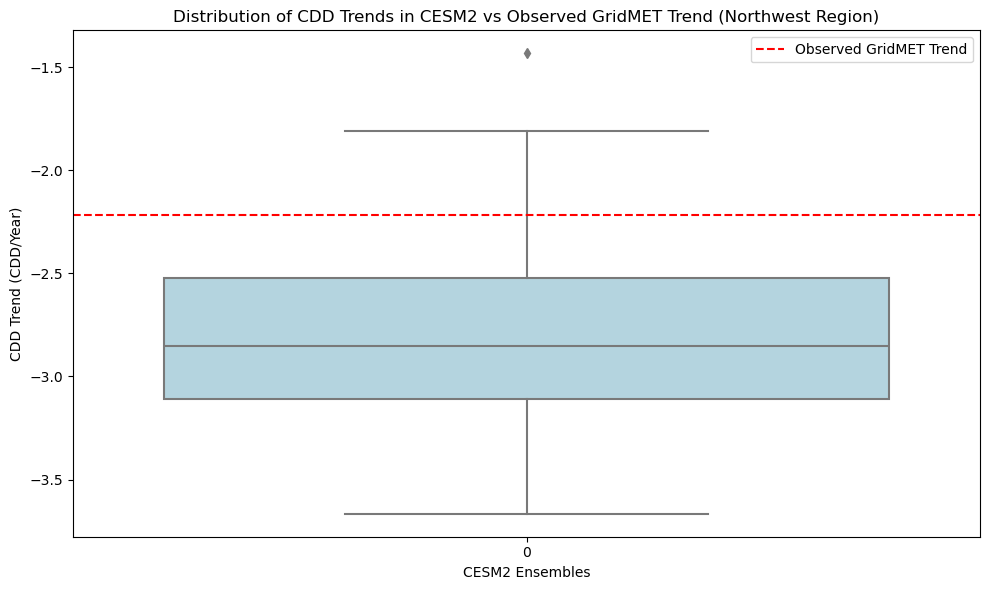

Saved the plot to /home/shawn_preston/CESM2PAPERFIGURES/CDD_Trends_Boxplot_with_Observed_Northwest.pdf


In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import regionmask

# Function to mask data for the Northwest region
def mask_northwest_region(data, shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    northwest_region = gdf[gdf['RegionName'] == 'Northwest']
    lon_1d = data['lon'].values
    lat_1d = data['lat'].values
    mask = regionmask.mask_geopandas(northwest_region, lon_1d, lat_1d)
    land_mask = mask.notnull()
    masked_data = data.where(land_mask, drop=True)
    return masked_data

# Paths
cesm2_data_path = '/home/shawn_preston/daysbelow0ensemble/cdd_trend_analysis.nc'
observed_data_path = '/home/shawn_preston/daysbelow0ensemble/gridmet_trends_cdd_analysis.nc'
shapefile_path = '/home/shawn_preston/NCA/NCA_Regions.shp'
output_plot_path = '/home/shawn_preston/CESM2PAPERFIGURES/CDD_Trends_Boxplot_with_Observed_Northwest.pdf'

# Load CESM2 trend data
cesm2_data = xr.open_dataset(cesm2_data_path)
cesm2_trends = cesm2_data['ensemble_trends']

# Mask CESM2 data for the Northwest region
cesm2_trends_nw = mask_northwest_region(cesm2_trends, shapefile_path)

# Load observed trend data
observed_data = xr.open_dataset(observed_data_path)
observed_trend = observed_data['observed_trends']

# Mask observed data for the Northwest region
observed_trend_nw = mask_northwest_region(observed_trend, shapefile_path)

# Calculate mean trend for observed data
observed_trend_mean_nw = observed_trend_nw.mean(dim=['lat', 'lon']).values

# Calculate the distribution of CESM2 trends
cesm2_trends_mean_nw = cesm2_trends_nw.mean(dim=['lat', 'lon']).values

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=cesm2_trends_mean_nw, color='lightblue')
plt.axhline(y=observed_trend_mean_nw, color='r', linestyle='--', label='Observed GridMET Trend')

# Customize the plot
plt.title('Distribution of CDD Trends in CESM2 vs Observed GridMET Trend (Northwest Region)')
plt.ylabel('CDD Trend (CDD/Year)')
plt.xlabel('CESM2 Ensembles')
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig(output_plot_path, format='pdf', dpi=600)
plt.show()

print(f"Saved the plot to {output_plot_path}")
